# Final Course Project

Yueh-Lin Tsai  
2024-12-11

This is Final Course Project

# Import libraries

## R library

In [ ]:
library(reticulate)
#use_condaenv("smm638", required = TRUE)
library(car)
library(sna)
library(ergm)
library(dplyr)
library(tidyr)

## Python library

In [ ]:
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite as bp
import matplotlib.pyplot as plt
import numpy as np
import itertools
from IPython.display import Image
import matplotlib
from graph_tool.all import *
import random

# Load data

## HR_edges.csv

In [ ]:
# load data
fr = pd.read_csv('/Users/adam/Desktop/Bayes/Class/Network_Analytics/SMM638/FCP/deezer_clean_data/HR_edges.csv')
# data preview
fr.head()

   node_1  node_2
0       0    4076
1       0   29861
2       0   53717
3       0   23820
4       0   39945

## HR_genres.json

In [ ]:
import json
with open('/Users/adam/Desktop/Bayes/Class/Network_Analytics/SMM638/FCP/deezer_clean_data/HR_genres.json', 'r') as f:
    pr_json = json.load(f)
pr_json["11542"]

['Indie Rock', 'Indie Pop/Folk', 'International Pop', 'Rap/Hip Hop', 'Pop', 'Rock', 'Indie Pop', 'Alternative']

### Convert the dictionary into a Pandas

In [ ]:
pr = pd.json_normalize(pr_json).T
pr.rename({0: 'genres'}, axis=1, inplace=True)
pr.head()

                                                  genres
13357                                              [Pop]
11542  [Indie Rock, Indie Pop/Folk, International Pop...
11543                                 [Dance, Pop, Rock]
11540                     [International Pop, Jazz, Pop]
11541                                      [Rap/Hip Hop]

### Separate rows

In [ ]:
pr = pr.explode('genres')
pr.reset_index(inplace=True)
pr.rename({'index': 'user_id'}, axis=1, inplace=True)
pr.head()

  user_id             genres
0   13357                Pop
1   11542         Indie Rock
2   11542     Indie Pop/Folk
3   11542  International Pop
4   11542        Rap/Hip Hop

# two-mode (Bipartite) networks

## data botton_nodes top_nodes edges

In [ ]:
bottom_nodes = pr["user_id"].drop_duplicates().reset_index(drop=True).to_numpy()
top_nodes = pr["genres"].drop_duplicates().reset_index(drop=True).to_numpy()
edges = pr[['user_id', 'genres']].values.tolist()

## Graph creation

In [ ]:
# empty graph
bg = nx.Graph()
# add nodes
bg.add_nodes_from(bottom_nodes, bipartite=0)
bg.add_nodes_from(top_nodes, bipartite=1)
# get nx object
bg.add_edges_from(edges)
# `is bipartite` check
is_bip = nx.is_bipartite(bg)

## Weighted projections of the two-mode networks

In [ ]:
#g_b_w = bp.weighted_projected_graph(bg, bottom_nodes, ratio=True)
g_t_w = bp.weighted_projected_graph(bg, top_nodes, ratio=True)

## plot two-mode networks network

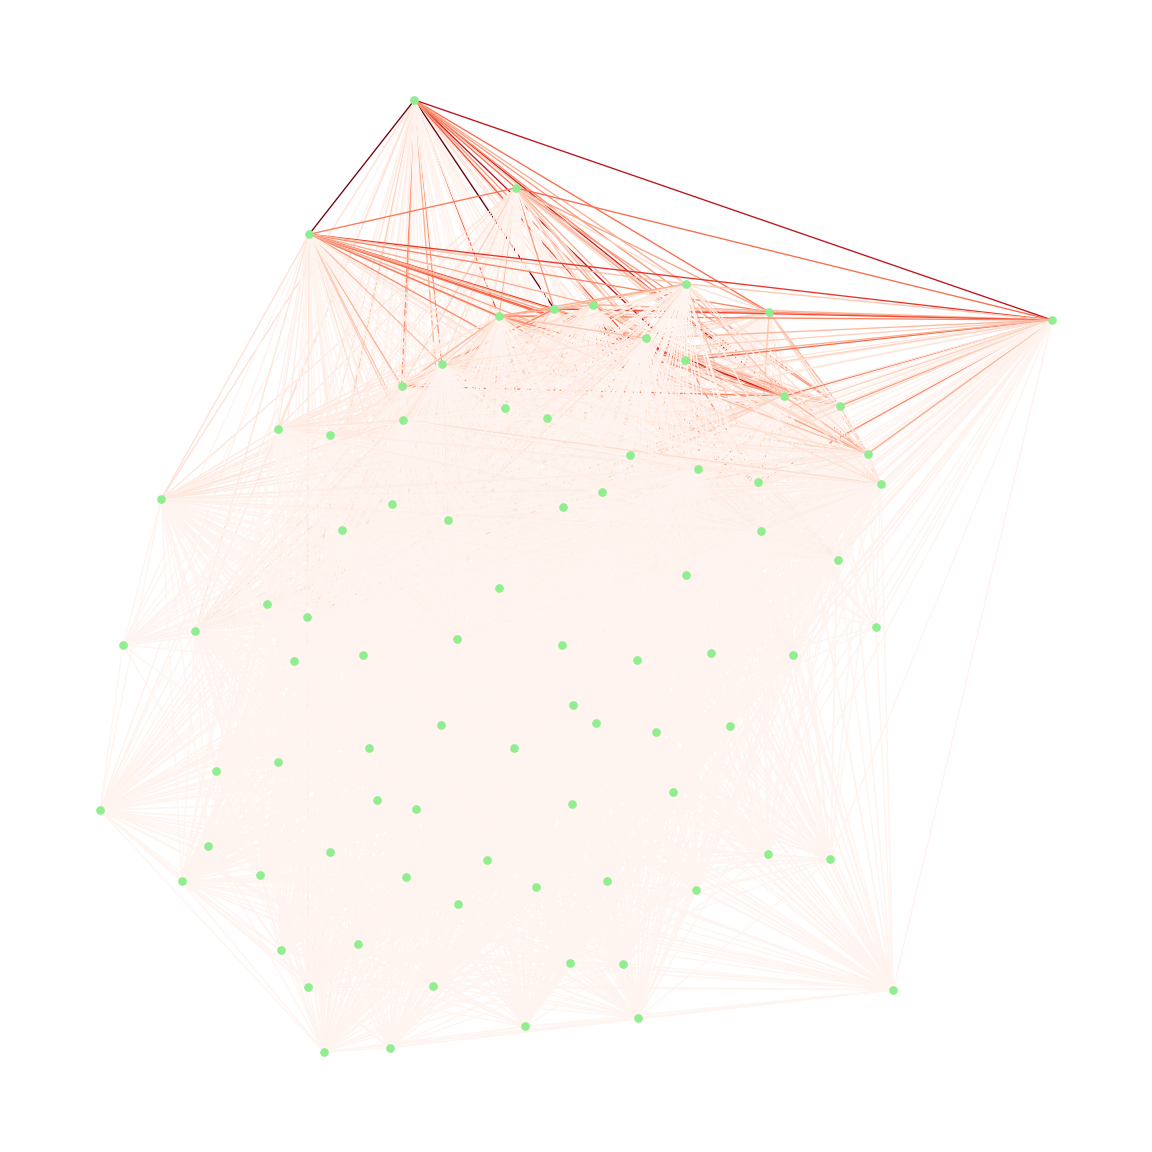

In [ ]:
# Create the figure and specify the size
plt.figure(figsize=(12, 12))

# Draw the network
edges = g_t_w.edges(data=True)
weights = [w["weight"] for u, v, w in edges]
vmin = min(weights)
vmax = max(weights)

pos = nx.kamada_kawai_layout(g_t_w)
nx.draw(
    g_t_w,
    pos,
    with_labels=False,
    node_color="lightgreen",
    node_size=30,
    edge_color=weights,
    edge_cmap=plt.cm.Reds,
    edge_vmin=vmin,
    edge_vmax=vmax,
)

# Add text annotation if needed
plt.text(1, 1, "A", fontsize=12, ha="center")

# Show plot
plt.show()

# Create Z matrix

## create X matrix and Z matrix

In [ ]:
user_genre_matrix = pr.pivot_table(index='user_id', columns='genres', aggfunc=lambda x: 1, fill_value=0)

# calculate genre-genre matrix Z
Z = np.dot(user_genre_matrix.T, user_genre_matrix)
# print(Z)

# change ndarray Z to DataFrame
Z_df = pd.DataFrame(Z, index=user_genre_matrix.columns, columns=user_genre_matrix.columns)

Z_df

genres               Acoustic Blues  African Music  ...  Vocal jazz  West Coast
genres                                              ...                        
Acoustic Blues                   14              2  ...           4           0
African Music                     2            107  ...           9           2
Alternative                      12             80  ...         313          72
Alternative Country               2              1  ...          14           0
Asian Music                       0              3  ...           4           2
...                             ...            ...  ...         ...         ...
Trance                            0              8  ...           9           7
Tropical                          0              3  ...           3           0
Urban Cowboy                      0              3  ...           7           1
Vocal jazz                        4              9  ...         374           0
West Coast                        0     

# Community Detection

## Visualize the network

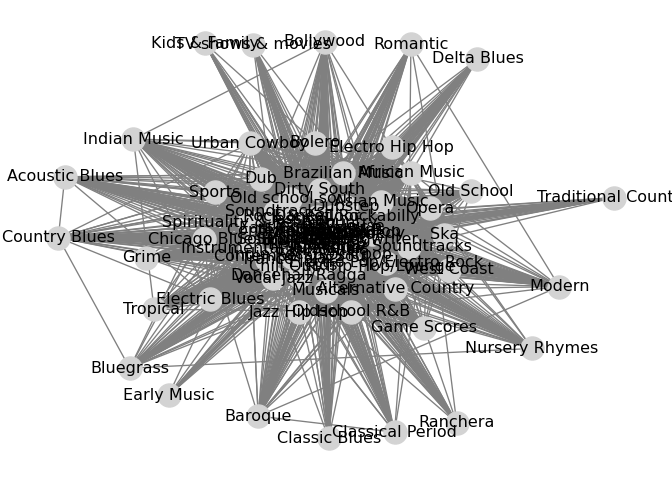

In [ ]:
# fix node positions for better visualization
pos = nx.spring_layout(g_t_w, seed=123)
# draw the network
nx.draw(
    g_t_w, pos, with_labels=True, node_color="lightgray", node_size=300, edge_color="gray"
)

## Community detection using Girvan-Newman’s algorithm

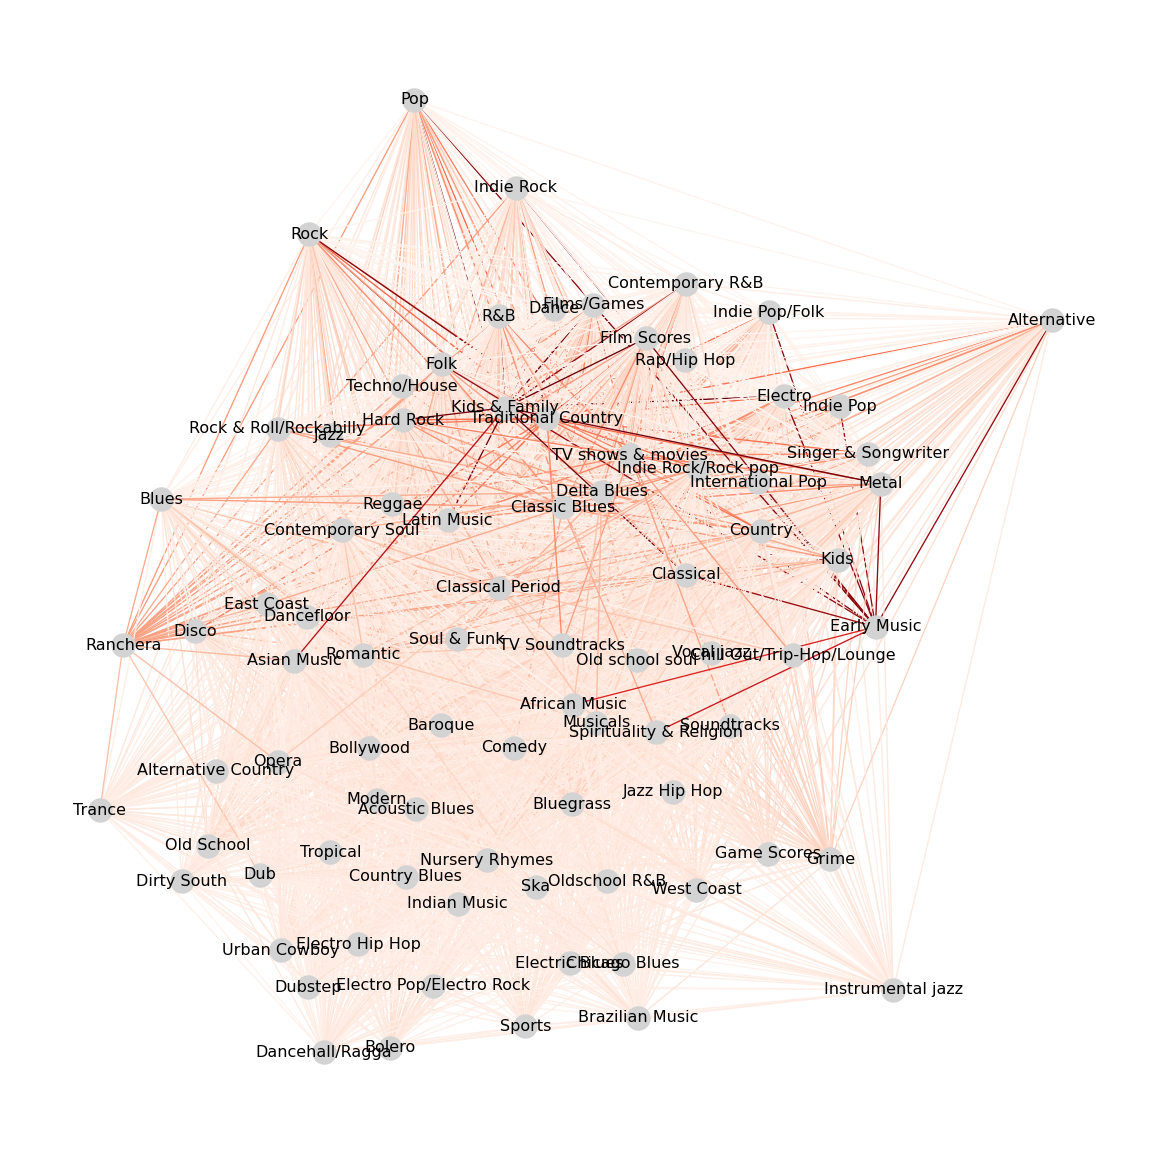

In [ ]:
# edge betweenness centrality
edge_betweenness = nx.edge_betweenness_centrality(g_t_w)
# set the value min and max make color lookable
vmin = min(edge_betweenness.values())
vmax = max(edge_betweenness.values())
# network visualization
pos = nx.kamada_kawai_layout(g_t_w)
plt.figure(figsize=(12, 12))
nx.draw(
    g_t_w,
    pos,
    with_labels=True,
    node_color="lightgray",
    node_size=300,
    edgelist=edge_betweenness.keys(),
    edge_color=list(edge_betweenness.values()),
    edge_cmap=plt.cm.Reds,
    edge_vmin=vmin,
    edge_vmax=vmax,
)

## Community detection using Louvaine’s algorithm (Z matrix)

### Change Z matrix to Graph

In [ ]:
g_z_matrix = nx.Graph()

# add node
for node in Z_df.columns:
    g_z_matrix.add_node(node)

# add edges
for i in Z_df.columns:
    for j in Z_df.columns:
        if i != j and Z_df.loc[i, j] > 0:
            g_z_matrix.add_edge(i, j, weight=Z_df.loc[i, j])

### Fit the Louvain algorithm to the weighted network

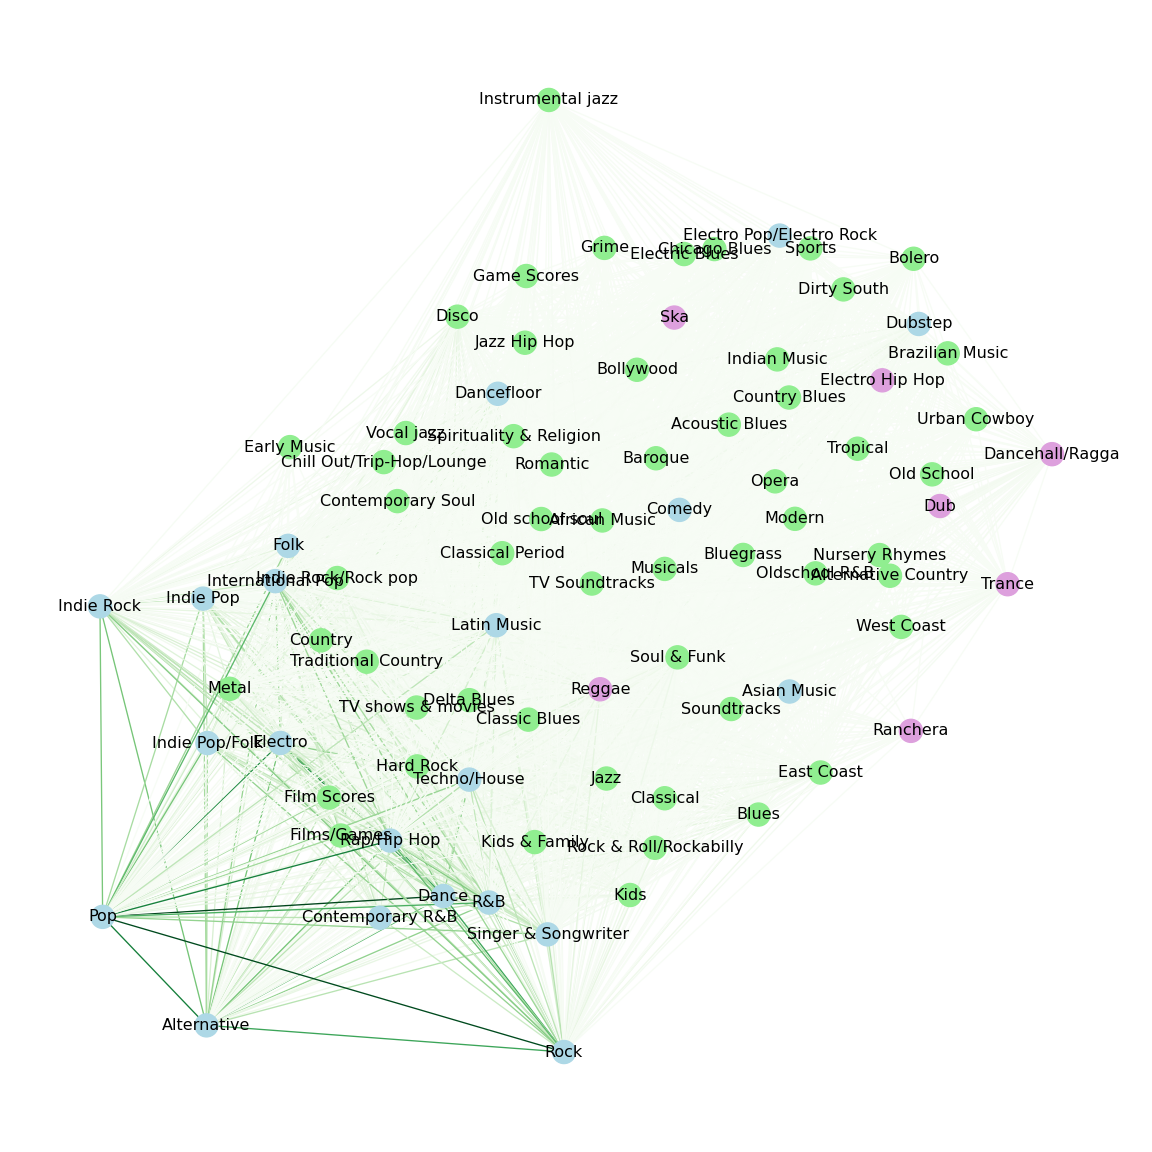

In [ ]:
# fit the Louvain algorithm to the weighted network
fit = nx.community.louvain_communities(g_z_matrix, weight="weight")
# retrieve the communities
communities = tuple(sorted(c) for c in fit)
# visualize the network with the identified communities
colors = [
    (
        "plum" if node in communities[0]
        else "lightgreen" if node in communities[1]
        else "lightblue"
    )
    for node in g_z_matrix.nodes
]
# visualize the network
pos = nx.kamada_kawai_layout(g_z_matrix)
plt.figure(figsize=(12, 12))
nx.draw(
    g_z_matrix,
    pos,
    with_labels=True,
    node_color=colors,
    node_size=300,
    edge_color=[g_z_matrix[u][v]["weight"] for u, v in g_z_matrix.edges],
    edge_cmap=plt.cm.Greens,
    #alpha=0.5,
)

# Weighted Stochastic Blockmodeling (WSBM)

## Change NetworkX graph into graph-tool graph

In [ ]:
# create graph-tool's graph
g_z_matrix_WSBM = Graph(directed=False)

# add node
vprops = g_z_matrix_WSBM.new_vertex_property("string")
vertices = {}
for node in g_z_matrix.nodes:
    v = g_z_matrix_WSBM.add_vertex()
    vertices[node] = v
    vprops[v] = node

g_z_matrix_WSBM.vp["name"] = vprops

# add edge
eweights = g_z_matrix_WSBM.new_edge_property("float")
for u, v, data in g_z_matrix.edges(data=True):
    edge = g_z_matrix_WSBM.add_edge(vertices[u], vertices[v])
    eweights[edge] = data["weight"]

g_z_matrix_WSBM.ep["weight"] = eweights  # add weight to graph

## Inferring the Modular Structure of Networks with Weighted Stochastic Blockmodeling

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x331d15e20, at 0x32baebcb0>, <GraphView object, directed, with 97 vertices and 96 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x32af666f0, at 0x32bae92e0>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x32af666f0, at 0x32af67710>, False), at 0x32af666f0>, <VertexPropertyMap object with value type 'vector<double>', for Graph 0x32af666f0, at 0x32baea870>)

(-0.5, 799.5, 798.5, -0.5)

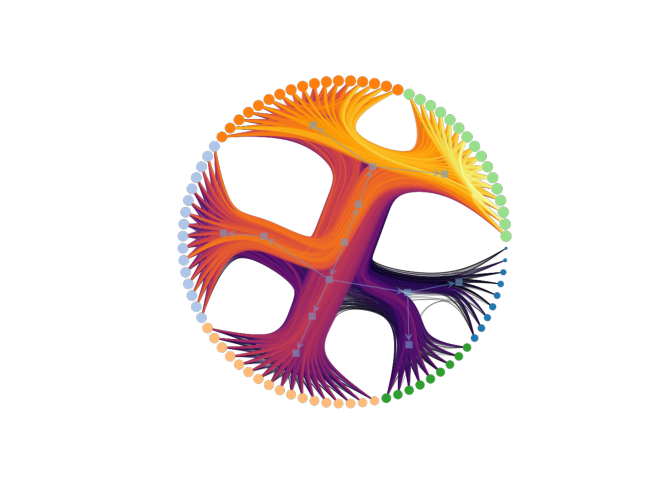

In [ ]:
# set random seed
seed = 41
random.seed(seed)
np.random.seed(seed)
graph_tool.all.seed_rng(seed)

# model fit
state = minimize_nested_blockmodel_dl(
    g_z_matrix_WSBM, state_args=dict(recs=[g_z_matrix_WSBM.ep.weight], rec_types=["real-exponential"])
)
# improve solution with merge-split
for i in range(100):
    ret = state.multiflip_mcmc_sweep(niter=10, beta=np.inf)
state.draw(
    edge_color=prop_to_size(g_z_matrix_WSBM.ep.weight, power=1, log=True),
    ecmap=(matplotlib.cm.inferno, 0.6),
    eorder=g_z_matrix_WSBM.ep.weight,
    edge_pen_width=prop_to_size(g_z_matrix_WSBM.ep.weight, 1, 4, power=1, log=True),
    edge_gradient=[],
    output_size=(800, 800),
    output="genre-wsbm.png",
)

## Getting a Multi-Level Community Classification

In [ ]:
levels = state.get_bs()

level_communities = []

for level_idx, level in enumerate(levels):
    community_mapping = {}
    for v_idx, community_id in enumerate(level):
        if community_id not in community_mapping:
            community_mapping[community_id] = []
        community_mapping[community_id].append(g_z_matrix_WSBM.vp["name"][v_idx])
    
    level_communities.append(community_mapping)
    print(f"Level {level_idx} Communities:")
    for community_id, nodes in community_mapping.items():
        print(f"  Community {community_id}: {nodes}")

Level 0 Communities:
  Community 61: ['Acoustic Blues', 'Baroque', 'Bluegrass', 'Bollywood', 'Country Blues', 'Indian Music', 'Modern', 'Nursery Rhymes', 'Tropical']
  Community 46: ['African Music', 'Alternative Country', 'Bolero', 'Chicago Blues', 'Dub', 'Electric Blues', 'Electro Hip Hop', 'Game Scores', 'Grime', 'Jazz Hip Hop', 'Old School', 'Oldschool R&B', 'Opera', 'Ska', 'Sports', 'Urban Cowboy', 'West Coast']
  Community 70: ['Alternative', 'Contemporary R&B', 'Dance', 'Electro', 'Film Scores', 'Films/Games', 'Indie Pop', 'Indie Pop/Folk', 'Indie Rock', 'International Pop', 'Pop', 'R&B', 'Rap/Hip Hop', 'Rock', 'Singer & Songwriter', 'Techno/House']
  Community 21: ['Asian Music', 'Brazilian Music', 'Chill Out/Trip-Hop/Lounge', 'Comedy', 'Dancehall/Ragga', 'Dirty South', 'Dubstep', 'Electro Pop/Electro Rock', 'Instrumental jazz', 'Musicals', 'Old school soul', 'Soundtracks', 'Spirituality & Religion', 'TV Soundtracks', 'Trance', 'Vocal jazz']
  Community 31: ['Blues', 'Classical

## Visualisation of WSBM

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x331d15e20, at 0x32afd0a70>

(-0.5, 720.5, 799.5, -0.5)

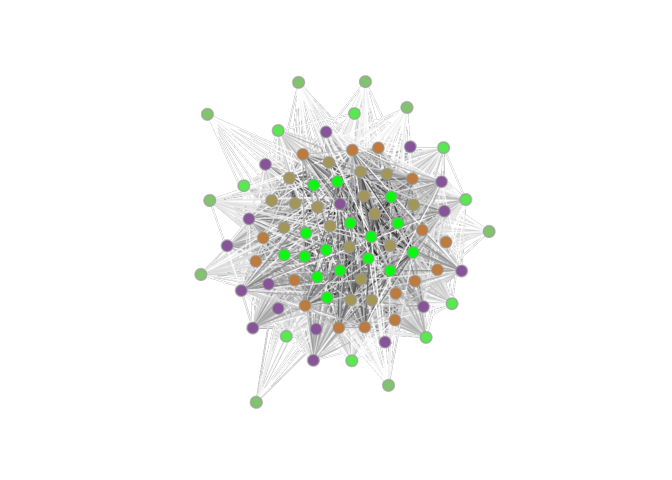

In [ ]:
# choose level
selected_level = 0

level_blocks = levels[selected_level]

# color
g_z_matrix_WSBM.vp["color"] = g_z_matrix_WSBM.new_vp("vector<double>")
color_map = {community_id: [np.random.rand(), np.random.rand(), np.random.rand()] for community_id in set(level_blocks)}
for v in g_z_matrix_WSBM.vertices():
    g_z_matrix_WSBM.vp["color"][v] = color_map[level_blocks[int(v)]]

# draw
graph_draw(
    g_z_matrix_WSBM,
    vertex_fill_color=g_z_matrix_WSBM.vp["color"],
    edge_color=prop_to_size(g_z_matrix_WSBM.ep.weight, power=1, log=True),
    output_size=(800, 800),
    output="level_0_visualization.png",
)

# Genres similarity network

## Building Genres similarity Networks

### calculate node_degree, clustering_coefficent

In [ ]:
g = nx.from_pandas_edgelist(fr, source="node_1", target="node_2")
nx.is_directed(g)

False

False

In [ ]:
# node degree
g_node_degree = nx.degree(g)
g_degree_dict = dict(g_node_degree)
# clustering coefficent
g_clustering = nx.clustering(g)

In [ ]:
node_metrics = pd.DataFrame({
    'user_id': list(g_degree_dict.keys()),
    'node_degree': list(g_degree_dict.values()),
    'clustering_coefficient': [g_clustering[user_id] for user_id in g_degree_dict.keys()]
})
pr_new = pr
pr_new['user_id'] = pd.to_numeric(pr_new['user_id'], errors='coerce')

combined_data = pr_new.merge(node_metrics, on='user_id', how='left')

genres_attribute_data = combined_data.groupby('genres', as_index=False).agg(
    avg_node_degree=('node_degree', 'mean'),
    avg_clustering_coefficient=('clustering_coefficient', 'mean')
)

### load data from python

In [ ]:
fr_r <- py$fr
pr_r <- py$pr
# Z matrix
Z_df <- py$Z_df
genres_attribute_data_r <- py$genres_attribute_data

### create network from Z matrix

In [ ]:
Z_matrix <- as.matrix(Z_df)

In [ ]:
attribute_list <- do.call(list, genres_attribute_data_r)

In [ ]:
genres_net <- network(
        x = Z_matrix, directed = FALSE,
        vertex.attr = attribute_list
)

In [ ]:
genres_net

 Network attributes:
  vertices = 84 
  directed = FALSE 
  hyper = FALSE 
  loops = FALSE 
  multiple = FALSE 
  bipartite = FALSE 
  total edges= 2779 
    missing edges= 0 
    non-missing edges= 2779 

 Vertex attribute names: 
    avg_clustering_coefficient avg_node_degree genres vertex.names 

 Edge attribute names not shown 

## Network visualization

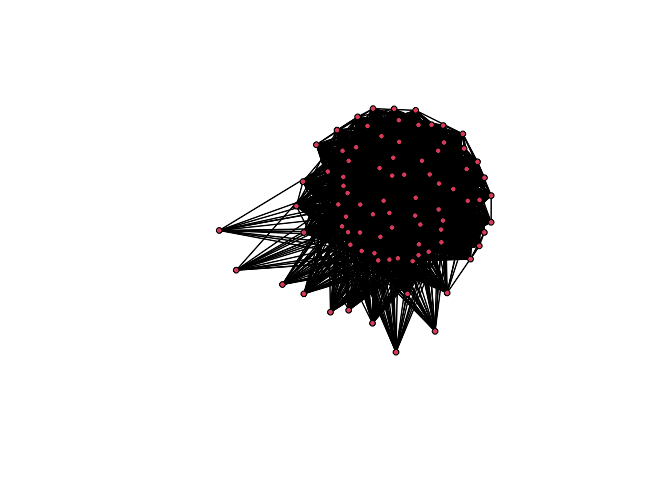

In [ ]:
plot(genres_net)

## Descriptive statistics

### density

In [ ]:
gden(genres_net)

[1] 0.7971888

### cug test

In [ ]:
cug.test(
        dat = genres_net, FUN = "gden", cmode = "size"
)


Univariate Conditional Uniform Graph Test

Conditioning Method: size 
Graph Type: digraph 
Diagonal Used: FALSE 
Replications: 1000 

Observed Value: 0.7971888 
Pr(X>=Obs): 0 
Pr(X<=Obs): 1 

### reciprocity

In [ ]:
grecip(genres_net, measure = "dyadic.nonnull")

Mut 
  1 

In [ ]:
cug.test(
        dat = genres_net, FUN = "grecip",
        FUN.args = list(measure = "dyadic.nonnull"), cmode = "edges"
)


Univariate Conditional Uniform Graph Test

Conditioning Method: edges 
Graph Type: digraph 
Diagonal Used: FALSE 
Replications: 1000 

Observed Value: 1 
Pr(X>=Obs): 0 
Pr(X<=Obs): 1 

## ERGM estimation

### Simple ‘edge’ model

In [ ]:
mod_rand <- ergm(formula = genres_net ~ edges)
summary(mod_rand)

Call:
ergm(formula = genres_net ~ edges)

Maximum Likelihood Results:

      Estimate Std. Error MCMC % z value Pr(>|z|)    
edges  1.36882    0.04212      0    32.5   <1e-04 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

     Null Deviance: 4833  on 3486  degrees of freedom
 Residual Deviance: 3516  on 3485  degrees of freedom
 
AIC: 3518  BIC: 3524  (Smaller is better. MC Std. Err. = 0)

### Edges & node attributes

In [ ]:
mod_homoph1 <- ergm(genres_net ~ edges + 
        absdiff("avg_node_degree") +
        absdiff("avg_clustering_coefficient")
)
summary(mod_homoph1)

Call:
ergm(formula = genres_net ~ edges + absdiff("avg_node_degree") + 
    absdiff("avg_clustering_coefficient"))

Maximum Likelihood Results:

                                    Estimate Std. Error MCMC % z value Pr(>|z|)
edges                                2.79217    0.08566      0   32.60   <1e-04
absdiff.avg_node_degree             -0.15128    0.01458      0  -10.38   <1e-04
absdiff.avg_clustering_coefficient -16.00433    1.43762      0  -11.13   <1e-04
                                      
edges                              ***
absdiff.avg_node_degree            ***
absdiff.avg_clustering_coefficient ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

     Null Deviance: 4833  on 3486  degrees of freedom
 Residual Deviance: 2926  on 3483  degrees of freedom
 
AIC: 2932  BIC: 2950  (Smaller is better. MC Std. Err. = 0)

In [ ]:
mod_homoph2 <- ergm(genres_net ~ edges + 
        absdiff("avg_node_degree") +
        absdiff("avg_clustering_coefficient") +
        nodecov("avg_node_degree") +
        nodecov("avg_clustering_coefficient"))
summary(mod_homoph2)

Call:
ergm(formula = genres_net ~ edges + absdiff("avg_node_degree") + 
    absdiff("avg_clustering_coefficient") + nodecov("avg_node_degree") + 
    nodecov("avg_clustering_coefficient"))

Maximum Likelihood Results:

                                     Estimate Std. Error MCMC % z value
edges                                0.587854   0.347280      0   1.693
absdiff.avg_node_degree             -0.091987   0.016128      0  -5.704
absdiff.avg_clustering_coefficient -14.339354   1.523784      0  -9.410
nodecov.avg_node_degree             -0.019085   0.008942      0  -2.134
nodecov.avg_clustering_coefficient  11.528102   1.068248      0  10.792
                                   Pr(>|z|)    
edges                                0.0905 .  
absdiff.avg_node_degree              <1e-04 ***
absdiff.avg_clustering_coefficient   <1e-04 ***
nodecov.avg_node_degree              0.0328 *  
nodecov.avg_clustering_coefficient   <1e-04 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 